In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [30]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        t, Xt = cIPFP.sample_trajectory(batch, dt, theta,  sigma, b, N, sde_solver, forwards)
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
    @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = solve_sde_RK(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in tqdm(range(IPFP_iterations)):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

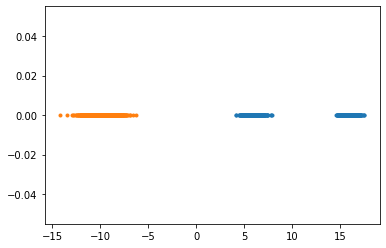

In [31]:
n = 1000
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 10
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 16
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 6
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [49]:
c = cIPFP(X1, X2,  number_time_steps=200, batch_size=150 , step_size = 0.0001, weights=[100])

In [50]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [51]:
theta_f[0][1].shape, theta_f[1]

((100,), ())

In [52]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

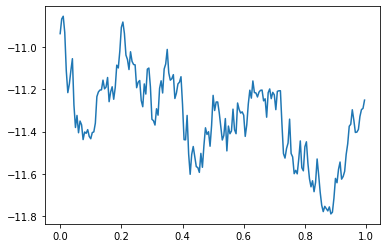

In [53]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [289]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [14]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [15]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [16]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 752 ms, sys: 10.3 ms, total: 762 ms
Wall time: 810 ms


DeviceArray(61.630344, dtype=float32)

In [17]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 16.8 ms, sys: 55 µs, total: 16.8 ms
Wall time: 10.5 ms


DeviceArray(68.25656, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [18]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.81 s, sys: 25.1 ms, total: 2.84 s
Wall time: 3.39 s


In [55]:
%%time
kek = gradient(theta_f, X1, True)

loss b 3741.302490234375
loss f 126.46263122558594



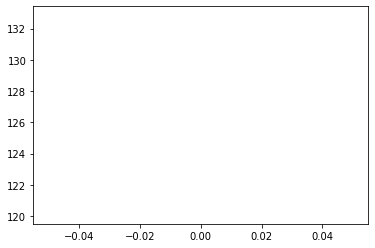

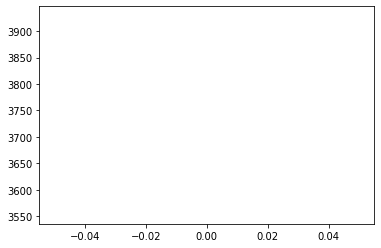

CPU times: user 47.2 s, sys: 20.2 ms, total: 47.2 s
Wall time: 46 s


In [56]:
%%time
c.fit(1,1)

loss b 3881.75048828125
loss f 126.32598876953125



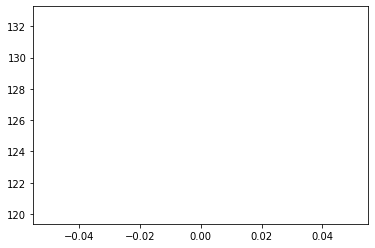

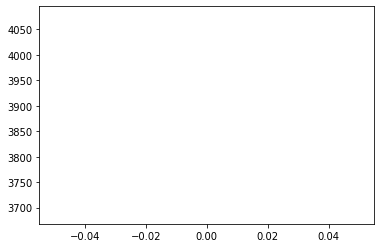

CPU times: user 1.7 s, sys: 363 ms, total: 2.07 s
Wall time: 1.38 s


In [57]:
%%time
c.fit(1,1)

In [ ]:
c.fit(150,30)

loss b 3940.979248046875
loss b 3307.608642578125
loss b 3548.485107421875
loss b 3247.37939453125
loss b 3669.549560546875
loss b 3370.8271484375


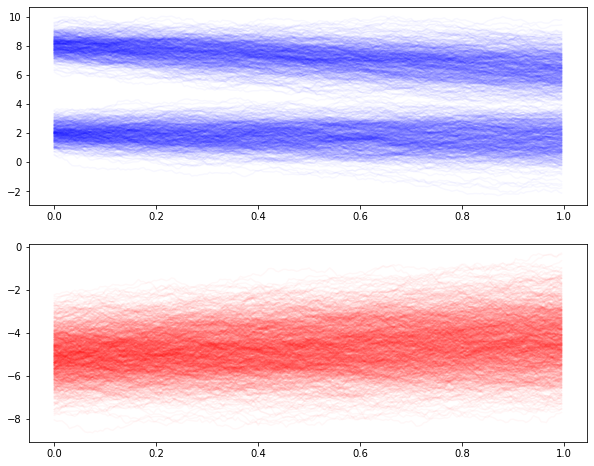

In [15]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
for x1 in X1:
    t, Xt = c.sample_trajectory(x1.reshape(1,-1),c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, forwards=True)
    axs[0].plot(t.flatten(), Xt.flatten(), 'b', alpha=0.03, )
BXt = []   

for x2 in X2:
    t_, Xt_ = c.sample_trajectory(x2.reshape(1,-1),c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver, forwards=False)
    BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xt_.flatten(), 'r', alpha=0.03)


In [62]:
# # @partial(jit, static_argnums=(0,2))
# npr.seed(0)
# def transport_batch(self, batch_x, forwards):
#     theta = self.theta_f if forwards else self.theta_b    
#     b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

#     def inner_loss_loop_23(x_):
#         t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=number_time_steps, theta=theta)
#         return Xt[:,-1,:]

#     return inner_loss_loop_23(batch_x)

In [70]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [71]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

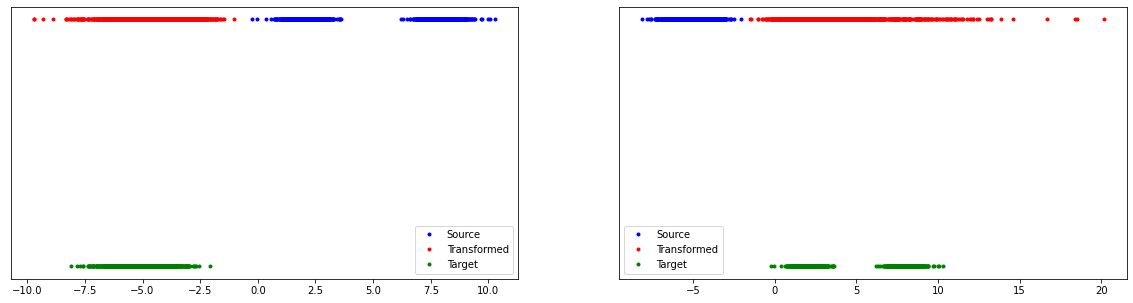

In [72]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

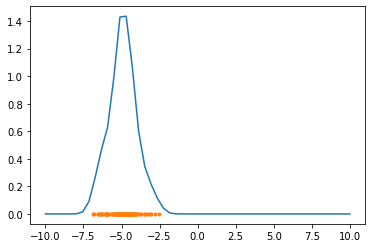

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

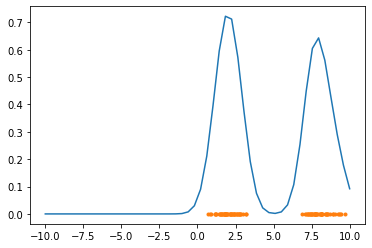

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")